In [1]:
#Import the libraries
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np
import pandas as pd 
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates


import datetime
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from mplfinance.original_flavor import candlestick_ohlc

import keras
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

from prophet import Prophet
from prophet.plot import plot_plotly

In [2]:
import pandas as pd

# Load the data
df_aapl = pd.read_csv('data/AAPL.csv')
df_adbe = pd.read_csv('data/ADBE.csv')
df_amd = pd.read_csv('data/AMD.csv')
df_cmcsa = pd.read_csv('data/CMCSA.csv')
df_cost = pd.read_csv('data/COST.csv')
df_intc = pd.read_csv('data/INTC.csv')
df_intu = pd.read_csv('data/INTU.csv')
df_msft = pd.read_csv('data/MSFT.csv')
df_qcom = pd.read_csv('data/QCOM.csv')
df_sbux = pd.read_csv('data/SBUX.csv')

dfs = [df_aapl, df_adbe, df_amd, df_cmcsa, df_cost, df_intc, df_intu, df_msft, df_qcom, df_sbux]

for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)


In [3]:
def remove_before_2005(df):
    df = df[df.index.year >= 2005]
    df.reset_index(inplace=True)
    return df

dfs = [remove_before_2005(df) for df in dfs]

df_aapl, df_adbe, df_amd, df_cmcsa, df_cost, df_intc, df_intu, df_msft, df_qcom, df_sbux = dfs

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def retrieve_closing_prices_only(data):
    return data[['Close']]

def min_max_scaling(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(data.values)
    return scaler, pd.DataFrame(normalized_data, columns=['Close'])


In [5]:
aapl_scaler, new_aapl_df = min_max_scaling(retrieve_closing_prices_only(df_aapl))
adbe_scaler, new_adbe_df = min_max_scaling(retrieve_closing_prices_only(df_adbe))
amd_scaler, new_amd_df = min_max_scaling(retrieve_closing_prices_only(df_amd))
cmcsa_scaler, new_cmcsa_df = min_max_scaling(retrieve_closing_prices_only(df_cmcsa))
cost_scaler, new_cost_df = min_max_scaling(retrieve_closing_prices_only(df_cost))
intc_scaler, new_intc_df = min_max_scaling(retrieve_closing_prices_only(df_intc))
intu_scaler, new_intu_df = min_max_scaling(retrieve_closing_prices_only(df_intu))
msft_scaler, new_msft_df = min_max_scaling(retrieve_closing_prices_only(df_msft))
qcom_scaler, new_qcom_df = min_max_scaling(retrieve_closing_prices_only(df_qcom))
sbux_scaler, new_sbux_df = min_max_scaling(retrieve_closing_prices_only(df_sbux))

In [6]:
new_aapl_df.head()

,Close
0,0.000000
1,0.000064
2,0.000119
3,0.000124
4,0.000588


In [7]:
import numpy as np

def split_and_reshape_data(dataframe, pred_days, company):
    prediction_days = pred_days
    
    train_size = int(np.ceil(len(dataframe) * 0.90))
    test_size = int(np.ceil(len(dataframe) * 0.10))
    
    print(f'The training size for {company.title()} is {train_size} rows')
    print(f'The testing size for {company.title()} is {test_size} rows')
    
    data_array = dataframe['Close'].values
    
    train_data = data_array[0: train_size]
    test_data = data_array[train_size - prediction_days: train_size + test_size]
    
    X_train, y_train, X_test, y_test = [], [], [], []
    
    for i in range(prediction_days, len(train_data)):
        X_train.append(train_data[i - prediction_days: i])
        y_train.append(train_data[i])
        
    for i in range(prediction_days, len(test_data)):
        X_test.append(test_data[i - prediction_days: i])
        y_test.append(test_data[i])
           
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    print(f'Data for {company.title()} split successfully')
    
    return X_train, y_train, X_test, y_test


In [8]:
X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl = split_and_reshape_data(new_aapl_df, 30, 'Apple')
X_train_adbe, y_train_adbe, X_test_adbe, y_test_adbe = split_and_reshape_data(new_adbe_df, 30, 'Adobe')
X_train_amd, y_train_amd, X_test_amd, y_test_amd = split_and_reshape_data(new_amd_df, 30, 'AMD')
X_train_cmcsa, y_train_cmcsa, X_test_cmcsa, y_test_cmcsa = split_and_reshape_data(new_cmcsa_df, 30, 'Comcast')
X_train_cost, y_train_cost, X_test_cost, y_test_cost = split_and_reshape_data(new_cost_df, 30, 'Costco')
X_train_intc, y_train_intc, X_test_intc, y_test_intc = split_and_reshape_data(new_intc_df, 30, 'Intel')
X_train_intu, y_train_intu, X_test_intu, y_test_intu = split_and_reshape_data(new_intu_df, 30, 'Intuit')
X_train_msft, y_train_msft, X_test_msft, y_test_msft = split_and_reshape_data(new_msft_df, 30, 'Microsoft')
X_train_qcom, y_train_qcom, X_test_qcom, y_test_qcom = split_and_reshape_data(new_qcom_df, 30, 'Qualcomm')
X_train_sbux, y_train_sbux, X_test_sbux, y_test_sbux = split_and_reshape_data(new_sbux_df, 30, 'Starbucks')


The training size for Apple is 4067 rows
The testing size for Apple is 452 rows
Data for Apple split successfully
The training size for Adobe is 4067 rows
The testing size for Adobe is 452 rows
Data for Adobe split successfully
The training size for Amd is 4067 rows
The testing size for Amd is 452 rows
Data for Amd split successfully
The training size for Comcast is 4067 rows
The testing size for Comcast is 452 rows
Data for Comcast split successfully
The training size for Costco is 4067 rows
The testing size for Costco is 452 rows
Data for Costco split successfully
The training size for Intel is 4067 rows
The testing size for Intel is 452 rows
Data for Intel split successfully
The training size for Intuit is 4067 rows
The testing size for Intuit is 452 rows
Data for Intuit split successfully
The training size for Microsoft is 4067 rows
The testing size for Microsoft is 452 rows
Data for Microsoft split successfully
The training size for Qualcomm is 4067 rows
The testing size for Qualc

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Function to create and train a linear model
def create_and_train_linear_model(X_train, y_train, X_test, y_test, company):
    print(f'=========For {company}=========')

    model = Sequential([
        Dense(1, input_shape=(X_train.shape[1],), activation='linear')  # Single Dense layer with a linear activation
    ])
    
    model.compile(optimizer=Adam(), loss=MeanSquaredError(), metrics=['mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])  
    y_pred = model.predict(X_test)
    
    return model, history, y_pred


=========For Apple=========
Epoch 1/50
127/127 [==============================] - 0s 2ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 2/50
127/127 [==============================] - 0s 728us/step - loss: 1.5222e-04 - mse: 1.5222e-04 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 3/50
127/127 [==============================] - 0s 672us/step - loss: 1.0174e-04 - mse: 1.0174e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 4/50
127/127 [==============================] - 0s 696us/step - loss: 1.0287e-04 - mse: 1.0287e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 5/50
127/127 [==============================] - 0s 689us/step - loss: 9.8520e-05 - mse: 9.8520e-05 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/50
15/15 [==============================] - 0s 498us/step
The MSE for Apple with Linear Model is 0.0014097134843580425


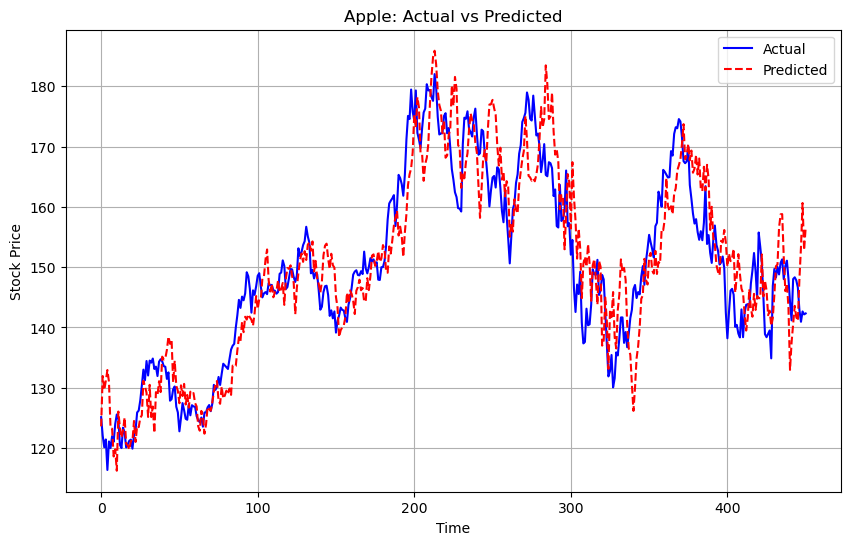

=========For Adobe=========
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 6.2211e-04 - mse: 6.2211e-04 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 2/50
127/127 [==============================] - 0s 712us/step - loss: 4.9579e-04 - mse: 4.9579e-04 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 3/50
127/127 [==============================] - 0s 733us/step - loss: 4.7111e-04 - mse: 4.7111e-04 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 4/50
127/127 [==============================] - 0s 785us/step - loss: 4.5354e-04 - mse: 4.5354e-04 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 5/50
127/127 [==============================] - 0s 765us/step - loss: 4.3977e-04 - mse: 4.3977e-04 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 6/50
127/127 [==============================] - 0s 720us/step - loss: 3.9471e-04 - mse: 3.9471e-04 - val_loss: 0.0098 - val_mse: 0.0098
Epoch 7/50
127/127 [==============================] - 0s 730us/step - loss: 3.6505e-04 - mse: 3.6505e-04 - val_loss: 0.008

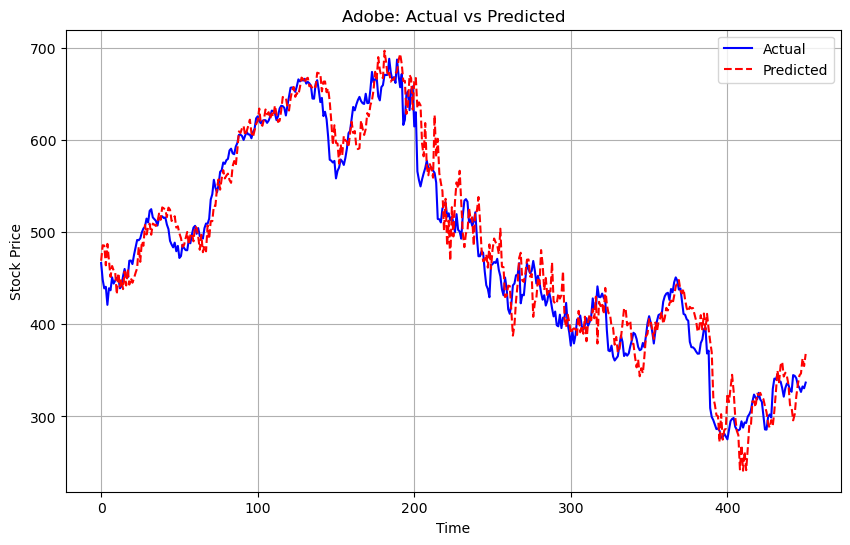

=========For AMD=========
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 4.2483e-04 - mse: 4.2483e-04 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 2/50
127/127 [==============================] - 0s 672us/step - loss: 3.8544e-04 - mse: 3.8544e-04 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 3/50
127/127 [==============================] - 0s 665us/step - loss: 3.2005e-04 - mse: 3.2005e-04 - val_loss: 0.0071 - val_mse: 0.0071
Epoch 4/50
127/127 [==============================] - 0s 657us/step - loss: 2.8136e-04 - mse: 2.8136e-04 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 5/50
127/127 [==============================] - 0s 688us/step - loss: 2.5878e-04 - mse: 2.5878e-04 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 6/50
127/127 [==============================] - 0s 713us/step - loss: 2.3145e-04 - mse: 2.3145e-04 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 7/50
127/127 [==============================] - 0s 688us/step - loss: 2.2160e-04 - mse: 2.2160e-04 - val_loss: 0.0044 

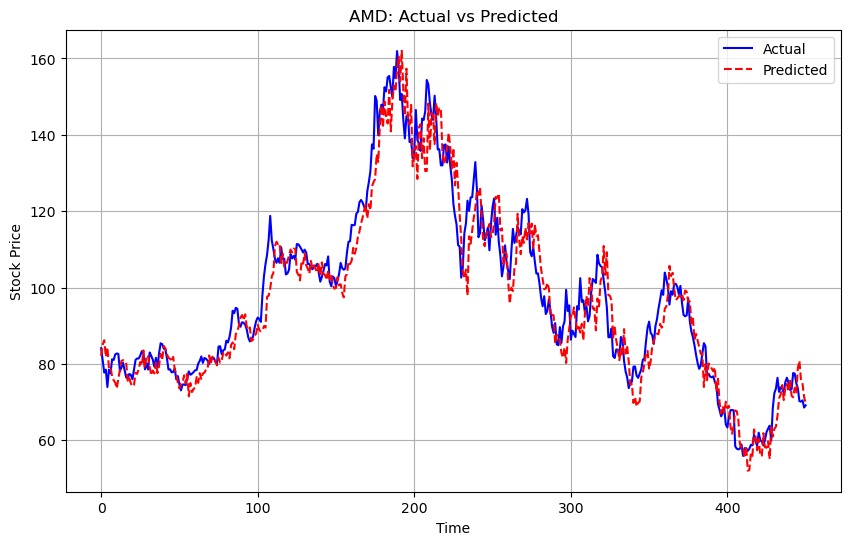

=========For Comcast=========
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.2159 - mse: 0.2159 - val_loss: 0.0176 - val_mse: 0.0176
Epoch 2/50
127/127 [==============================] - 0s 680us/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 3/50
127/127 [==============================] - 0s 666us/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 4/50
127/127 [==============================] - 0s 672us/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 5/50
127/127 [==============================] - 0s 704us/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 6/50
127/127 [==============================] - 0s 693us/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 7/50
127/127 [==============================] - 0s 688us/step - loss: 8.8950e-04 - mse: 8.8950e-04 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 8/50
127/127 [======

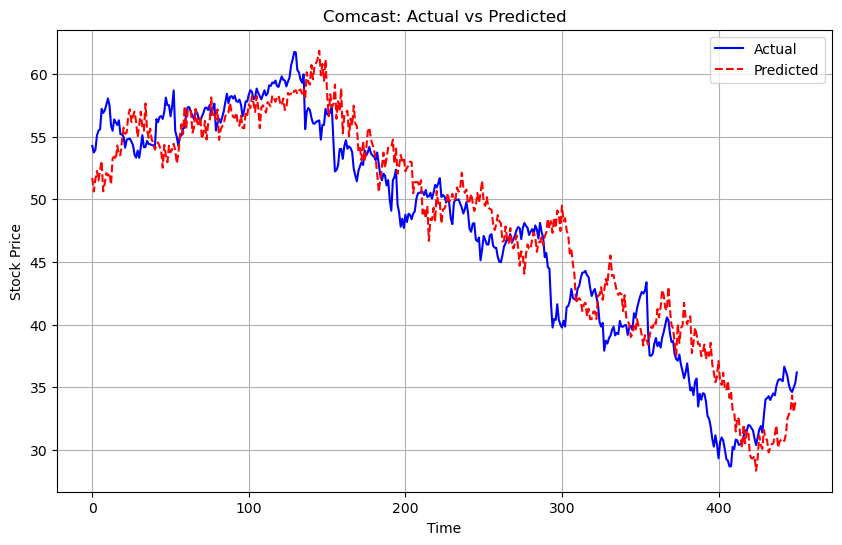

=========For Costco=========
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0857 - mse: 0.0857 - val_loss: 0.0641 - val_mse: 0.0641
Epoch 2/50
127/127 [==============================] - 0s 657us/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 3/50
127/127 [==============================] - 0s 672us/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 4/50
127/127 [==============================] - 0s 688us/step - loss: 4.3231e-04 - mse: 4.3231e-04 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 5/50
127/127 [==============================] - 0s 664us/step - loss: 1.8831e-04 - mse: 1.8831e-04 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 6/50
127/127 [==============================] - 0s 644us/step - loss: 1.0864e-04 - mse: 1.0864e-04 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 7/50
127/127 [==============================] - 0s 673us/step - loss: 8.6343e-05 - mse: 8.6343e-05 - val_loss: 0.0016 - val_mse: 0.0016
Epo

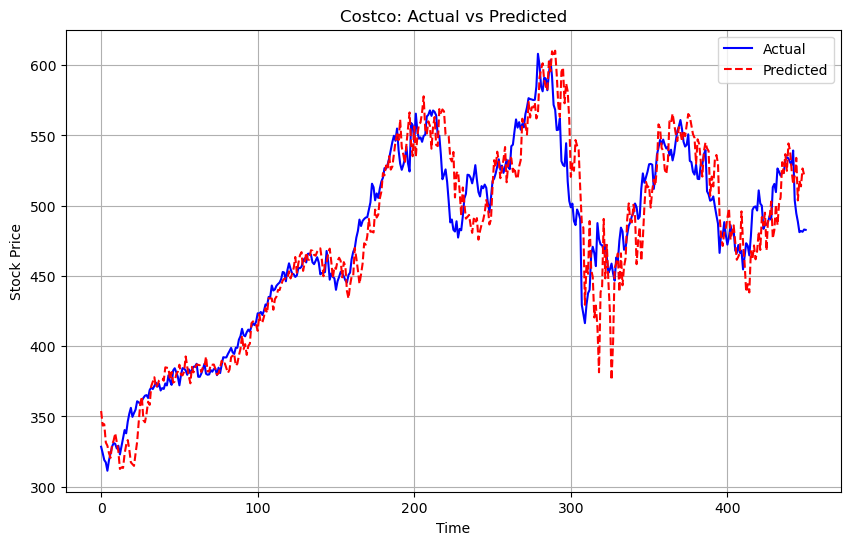

=========For Intel=========
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.2908 - mse: 0.2908 - val_loss: 0.0207 - val_mse: 0.0207
Epoch 2/50
127/127 [==============================] - 0s 664us/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 3/50
127/127 [==============================] - 0s 644us/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 4/50
127/127 [==============================] - 0s 647us/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 5/50
127/127 [==============================] - 0s 650us/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 6/50
127/127 [==============================] - 0s 750us/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 7/50
127/127 [==============================] - 0s 683us/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 8/50
127/127 [================

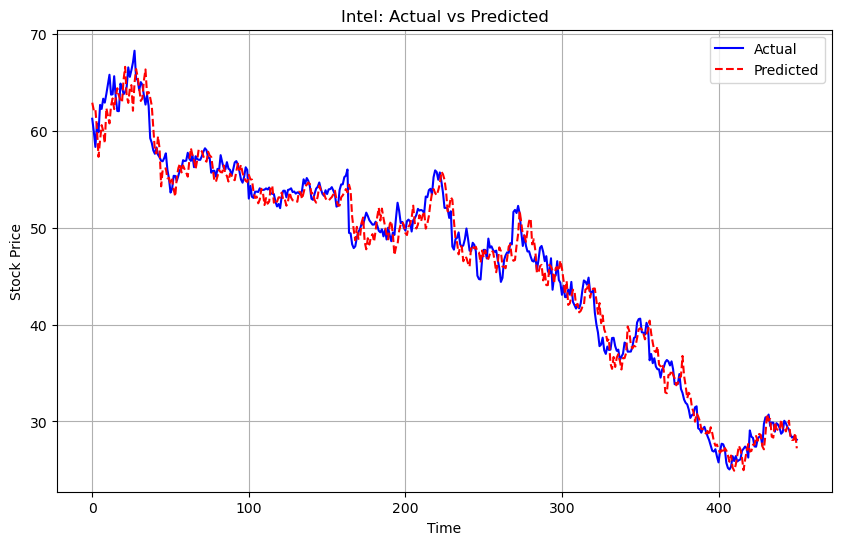

=========For Intuit=========
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.1028 - mse: 0.1028 - val_loss: 0.2243 - val_mse: 0.2243
Epoch 2/50
127/127 [==============================] - 0s 697us/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 3/50
127/127 [==============================] - 0s 678us/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0197 - val_mse: 0.0197
Epoch 4/50
127/127 [==============================] - 0s 664us/step - loss: 7.1300e-04 - mse: 7.1300e-04 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 5/50
127/127 [==============================] - 0s 671us/step - loss: 3.7196e-04 - mse: 3.7196e-04 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 6/50
127/127 [==============================] - 0s 661us/step - loss: 2.7716e-04 - mse: 2.7716e-04 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 7/50
127/127 [==============================] - 0s 862us/step - loss: 2.5531e-04 - mse: 2.5531e-04 - val_loss: 0.0087 - val_mse: 0.0087
Epo

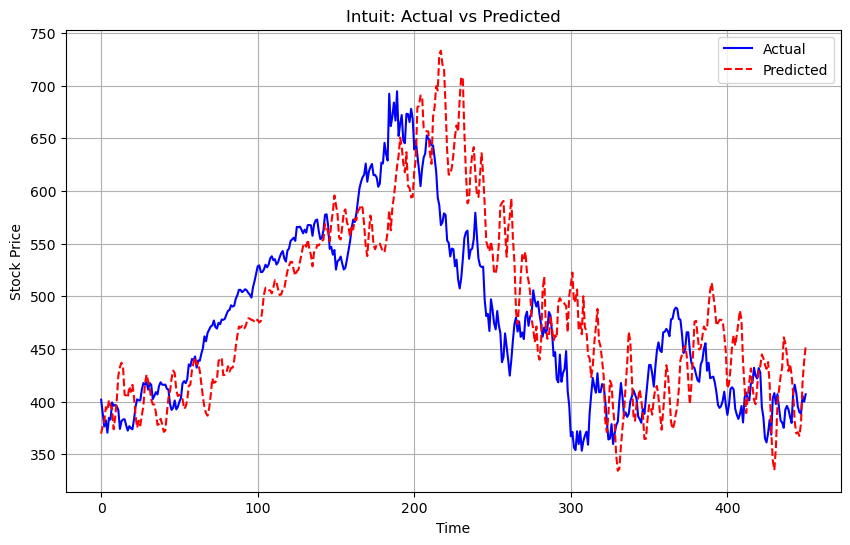

=========For Microsoft=========
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 3.4206e-04 - mse: 3.4206e-04 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 2/50
127/127 [==============================] - 0s 672us/step - loss: 2.9148e-04 - mse: 2.9148e-04 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 3/50
127/127 [==============================] - 0s 664us/step - loss: 2.8903e-04 - mse: 2.8903e-04 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 4/50
127/127 [==============================] - 0s 665us/step - loss: 2.4671e-04 - mse: 2.4671e-04 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 5/50
127/127 [==============================] - 0s 680us/step - loss: 2.3135e-04 - mse: 2.3135e-04 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 6/50
127/127 [==============================] - 0s 664us/step - loss: 2.2960e-04 - mse: 2.2960e-04 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/50
127/127 [==============================] - 0s 680us/step - loss: 2.0206e-04 - mse: 2.0206e-04 - val_loss: 0

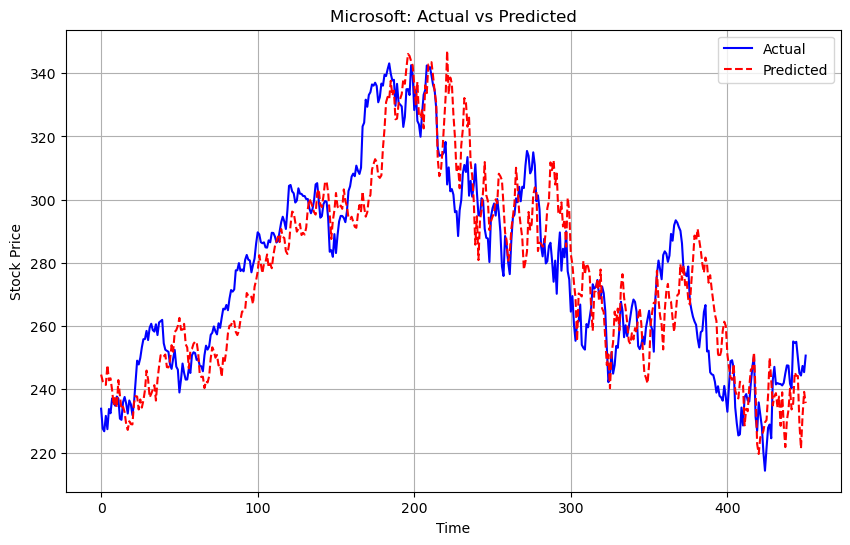

=========For Qualcomm=========
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0209 - val_mse: 0.0209
Epoch 2/50
127/127 [==============================] - 0s 672us/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 3/50
127/127 [==============================] - 0s 672us/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0121 - val_mse: 0.0121
Epoch 4/50
127/127 [==============================] - 0s 657us/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0088 - val_mse: 0.0088
Epoch 5/50
127/127 [==============================] - 0s 664us/step - loss: 9.9393e-04 - mse: 9.9393e-04 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 6/50
127/127 [==============================] - 0s 656us/step - loss: 7.7817e-04 - mse: 7.7817e-04 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 7/50
127/127 [==============================] - 0s 664us/step - loss: 6.2255e-04 - mse: 6.2255e-04 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 8/5

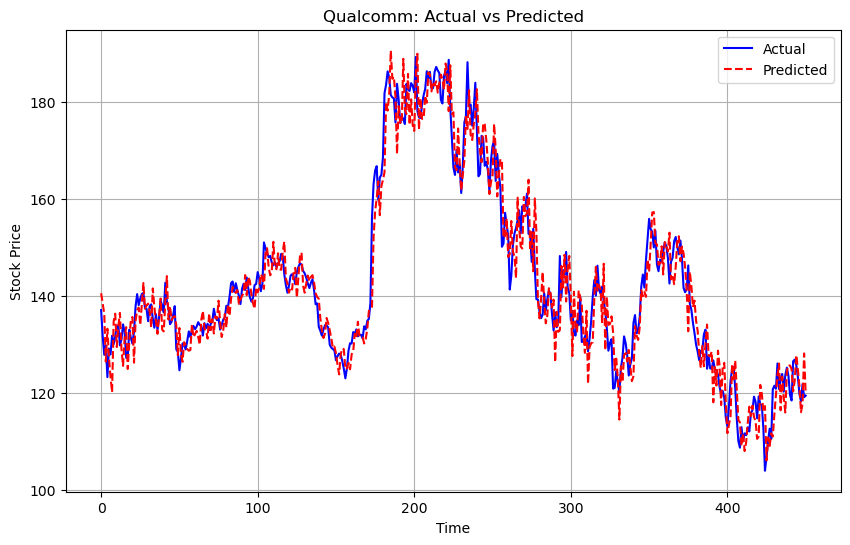

=========For Starbucks=========
Epoch 1/50
127/127 [==============================] - 0s 1ms/step - loss: 0.3841 - mse: 0.3841 - val_loss: 0.1775 - val_mse: 0.1775
Epoch 2/50
127/127 [==============================] - 0s 672us/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 3/50
127/127 [==============================] - 0s 752us/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 4/50
127/127 [==============================] - 0s 688us/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 5/50
127/127 [==============================] - 0s 657us/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 6/50
127/127 [==============================] - 0s 658us/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 7/50
127/127 [==============================] - 0s 672us/step - loss: 9.7612e-04 - mse: 9.7612e-04 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 8/50
127/127 [====

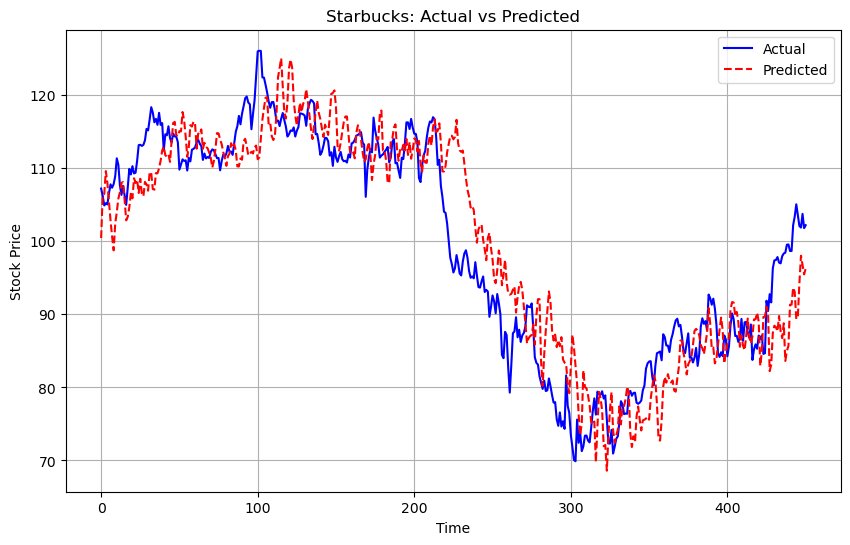


Aggregate MSE for Linear models across all stocks:  0.0022381800507156662

Mean MSE for Linear model:  0.0022381800507156662


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to plot predictions vs actual values with inverse scaling
def plot_predictions_vs_truth(y_test, y_pred, company_name, scaler):
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
    plt.title(f'{company_name}: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def predictions_linear_mse(company, model, X_test, y_test, scaler):
    global mse_linear
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_linear += mse
    
    print(f'The MSE for {company} with Linear Model is {mse}')
    plot_predictions_vs_truth(y_test, y_pred, company, scaler)
    
    return y_pred, y_test, mse

linear_models = {}
linear_predictions = {}
mse_linear = 0
mse_list = []

scalers = {
    'Apple': aapl_scaler,
    'Adobe': adbe_scaler,
    'AMD': amd_scaler,
    'Comcast': cmcsa_scaler,
    'Costco': cost_scaler,
    'Intel': intc_scaler,
    'Intuit': intu_scaler,
    'Microsoft': msft_scaler,
    'Qualcomm': qcom_scaler,
    'Starbucks': sbux_scaler
}

linear_models['Apple'], _, linear_predictions['Apple'] = create_and_train_linear_model(X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl, 'Apple')
y_pred_aapl, y_test_aapl, mse_aapl = predictions_linear_mse('Apple', linear_models['Apple'], X_test_aapl, y_test_aapl, scalers['Apple'])
mse_list.append(mse_aapl)

linear_models['Adobe'], _, linear_predictions['Adobe'] = create_and_train_linear_model(X_train_adbe, y_train_adbe, X_test_adbe, y_test_adbe, 'Adobe')
y_pred_adbe, y_test_adbe, mse_adbe = predictions_linear_mse('Adobe', linear_models['Adobe'], X_test_adbe, y_test_adbe, scalers['Adobe'])
mse_list.append(mse_adbe)

linear_models['AMD'], _, linear_predictions['AMD'] = create_and_train_linear_model(X_train_amd, y_train_amd, X_test_amd, y_test_amd, 'AMD')
y_pred_amd, y_test_amd, mse_amd = predictions_linear_mse('AMD', linear_models['AMD'], X_test_amd, y_test_amd, scalers['AMD'])
mse_list.append(mse_amd)

linear_models['Comcast'], _, linear_predictions['Comcast'] = create_and_train_linear_model(X_train_cmcsa, y_train_cmcsa, X_test_cmcsa, y_test_cmcsa, 'Comcast')
y_pred_cmcsa, y_test_cmcsa, mse_cmcsa = predictions_linear_mse('Comcast', linear_models['Comcast'], X_test_cmcsa, y_test_cmcsa, scalers['Comcast'])
mse_list.append(mse_cmcsa)

linear_models['Costco'], _, linear_predictions['Costco'] = create_and_train_linear_model(X_train_cost, y_train_cost, X_test_cost, y_test_cost, 'Costco')
y_pred_cost, y_test_cost, mse_cost = predictions_linear_mse('Costco', linear_models['Costco'], X_test_cost, y_test_cost, scalers['Costco'])
mse_list.append(mse_cost)

linear_models['Intel'], _, linear_predictions['Intel'] = create_and_train_linear_model(X_train_intc, y_train_intc, X_test_intc, y_test_intc, 'Intel')
y_pred_intc, y_test_intc, mse_intc = predictions_linear_mse('Intel', linear_models['Intel'], X_test_intc, y_test_intc, scalers['Intel'])
mse_list.append(mse_intc)

linear_models['Intuit'], _, linear_predictions['Intuit'] = create_and_train_linear_model(X_train_intu, y_train_intu, X_test_intu, y_test_intu, 'Intuit')
y_pred_intu, y_test_intu, mse_intu = predictions_linear_mse('Intuit', linear_models['Intuit'], X_test_intu, y_test_intu, scalers['Intuit'])
mse_list.append(mse_intu)

linear_models['Microsoft'], _, linear_predictions['Microsoft'] = create_and_train_linear_model(X_train_msft, y_train_msft, X_test_msft, y_test_msft, 'Microsoft')
y_pred_msft, y_test_msft, mse_msft = predictions_linear_mse('Microsoft', linear_models['Microsoft'], X_test_msft, y_test_msft, scalers['Microsoft'])
mse_list.append(mse_msft)

linear_models['Qualcomm'], _, linear_predictions['Qualcomm'] = create_and_train_linear_model(X_train_qcom, y_train_qcom, X_test_qcom, y_test_qcom, 'Qualcomm')
y_pred_qcom, y_test_qcom, mse_qcom = predictions_linear_mse('Qualcomm', linear_models['Qualcomm'], X_test_qcom, y_test_qcom, scalers['Qualcomm'])
mse_list.append(mse_qcom)

linear_models['Starbucks'], _, linear_predictions['Starbucks'] = create_and_train_linear_model(X_train_sbux, y_train_sbux, X_test_sbux, y_test_sbux, 'Starbucks')
y_pred_sbux, y_test_sbux, mse_sbux = predictions_linear_mse('Starbucks', linear_models['Starbucks'], X_test_sbux, y_test_sbux, scalers['Starbucks'])
mse_list.append(mse_sbux)

mean_mse_linear = mse_linear / len(linear_models)
print("\nAggregate MSE for Linear models across all stocks: ", mean_mse_linear)

mse_dense = mean_mse_linear
print("\nMean MSE for Linear model: ", mse_dense)


In [11]:
mse_linear

0.022381800507156664

In [13]:
mse_list
mse_results_linear=mse_list

In [14]:
import pickle

# Save the mse_results dictionary and mse_linear value to a file
with open('mse_results_and_linear.pkl', 'wb') as file:
    pickle.dump({'mse_results_linear': mse_results_linear, 'mse_linear': mse_linear}, file)

print("mse_results and mse_linear have been saved to mse_results_and_linear.pkl")

mse_results and mse_linear have been saved to mse_results_and_linear.pkl
